In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")

In [2]:
source_df = pd.read_csv("raw_data/found_df.csv")
source_df.head(2)

,Unnamed: 0,title,author,author_id,file_name,text_url
0,0,Арап Петра Великого,Александр Пушкин,0,aleksandr_pushkin_arap_petra_velikogo,https://ilibrary.ru/text/476/p.1/index.html
1,1,Дубровский,Александр Пушкин,0,aleksandr_pushkin_dubrovskij,https://ilibrary.ru/text/479/p.1/index.html


In [3]:
names = source_df["author"].unique()
ids = source_df["author_id"].unique()
names_arr = zip(ids,names)

data_dict = {}
for n in ids:
    with open("./stats-data/"+str(n)+".pkl", "rb") as fp:
        data_dict[n] = pickle.load(fp)


In [4]:
def get_name_by_id(aid):
    names_df = source_df[["author", "author_id"]].groupby("author_id").max()
    names = [name for name in names_df["author"]]
    return names[aid]

get_name_by_id(3)

'Антон Чехов'

### Распределение по длинам предложений

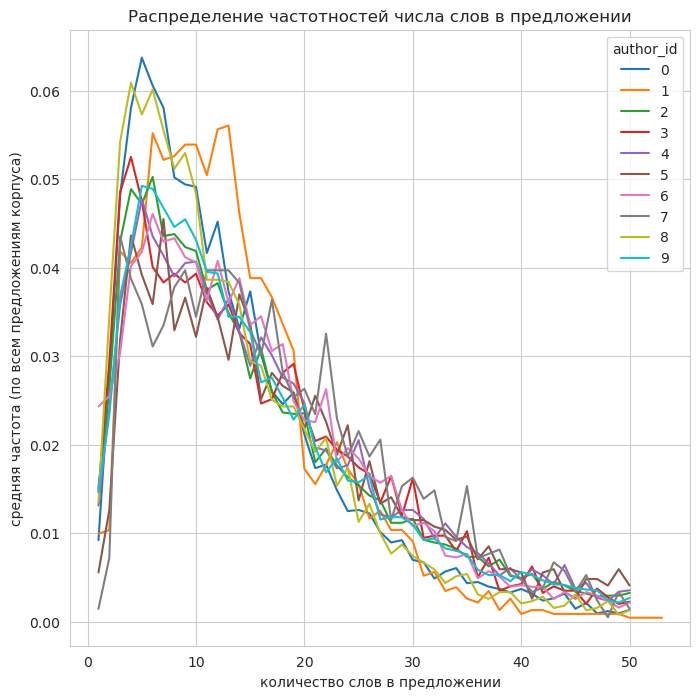

In [5]:
v_words = {}
df_all = pd.DataFrame([], columns=["sentence_length", "freq",'author_id'])
for author_id in ids:
    # можно было их все в кучу свалить, но я хочу иметь возможноть удобно отсекать 
    # предложения длины больше заданной
    v = Counter(data_dict[author_id]["sentence_length"])
    df = pd.DataFrame(sorted(list(v.items()), key=lambda x: x[0]), columns=["sentence_length", "freq"])
    df['author_id'] = pd.Series([author_id] * df.shape[0])
    df['freq'] = df['freq'] / df["freq"].sum()
    df['freq'] = df['freq'][:50]
    
    df_all = pd.concat([df_all, df], ignore_index=True)

plt.figure(figsize=(8,8))    
plt.title("Распределение частотностей числа слов в предложении")
plt.xlabel("количество слов в предложении")
plt.ylabel("средняя частота (по всем предложениям корпуса)")
sns.lineplot(data=df_all, x="sentence_length", y="freq", hue="author_id", palette="tab10", legend="full" )
plt.show()


### Распределение числа знаков препинания 

совокупное не так интересно как с разбивкой на длины. 

In [6]:
## "!\'()*,-./:;?

columns=["author_id", "sentence_length", 
         'sgn "', 'sgn !', "sgn '", "sgn (", "sgn )", "sgn *", 
         "sgn ,", "sgn -", "sgn .", "sgn :", "sgn ;","sgn ?"]

df_all = pd.DataFrame([], columns=columns)

for author_id in ids:
    df_all_tmp = pd.DataFrame(data_dict[author_id]["punctuation"], columns=columns[2:])
    df_all_tmp['sentence_length'] = pd.Series(data_dict[author_id]["sentence_length"])
    df_all_tmp['author_id'] = pd.Series([author_id] * df_all_tmp.shape[0])
    df_all_tmp = df_all_tmp[[
         "author_id", "sentence_length", 
         "sgn !", 'sgn "', "sgn '", "sgn (", "sgn )", "sgn *", 
         "sgn ,", "sgn -", "sgn .", "sgn :", "sgn ;","sgn ?"]]
    df_all = pd.concat([df_all, df_all_tmp])


In [7]:
df_aggr = df_all.groupby(['author_id','sentence_length']).mean().reset_index()

In [8]:
df_aggr.sample(10)

,author_id,sentence_length,"sgn """,sgn !,sgn ',sgn (,sgn ),sgn *,"sgn ,",sgn -,sgn .,sgn :,sgn ;,sgn ?
272,3,5,0.0,0.17801,0.0,0.005236,0.0,0.0,0.471204,0.041885,0.890052,0.005236,0.0,0.141361
923,9,87,0.0,0.0,0.0,0.0,0.0,0.0,14.0,2.0,4.0,0.0,0.0,0.0
294,3,27,0.0,0.166667,0.0,0.0,0.0,0.0,4.481481,0.222222,1.777778,0.185185,0.185185,0.055556
814,8,58,0.0,0.25,0.0,0.0,0.0,0.0,9.0,0.25,2.25,0.5,0.5,0.0
331,3,64,0.0,0.0,0.0,0.0,0.0,0.0,10.333333,0.333333,1.666667,0.0,0.0,0.0
311,3,44,0.0,0.071429,0.0,0.071429,0.071429,0.0,6.5,0.285714,1.5,0.142857,0.285714,0.0
810,8,54,0.0,0.0,0.0,0.0,0.0,0.0,8.75,0.5,2.25,0.25,0.75,0.25
687,7,6,0.0,0.261538,0.0,0.0,0.0,0.0,0.4,0.076923,0.923077,0.030769,0.0,0.138462
212,2,66,0.0,0.3,0.0,0.2,0.2,0.0,11.4,1.0,2.9,0.5,0.9,0.1
556,5,90,0.0,0.5,0.0,0.0,0.0,0.0,18.0,1.0,3.5,2.5,0.5,0.0


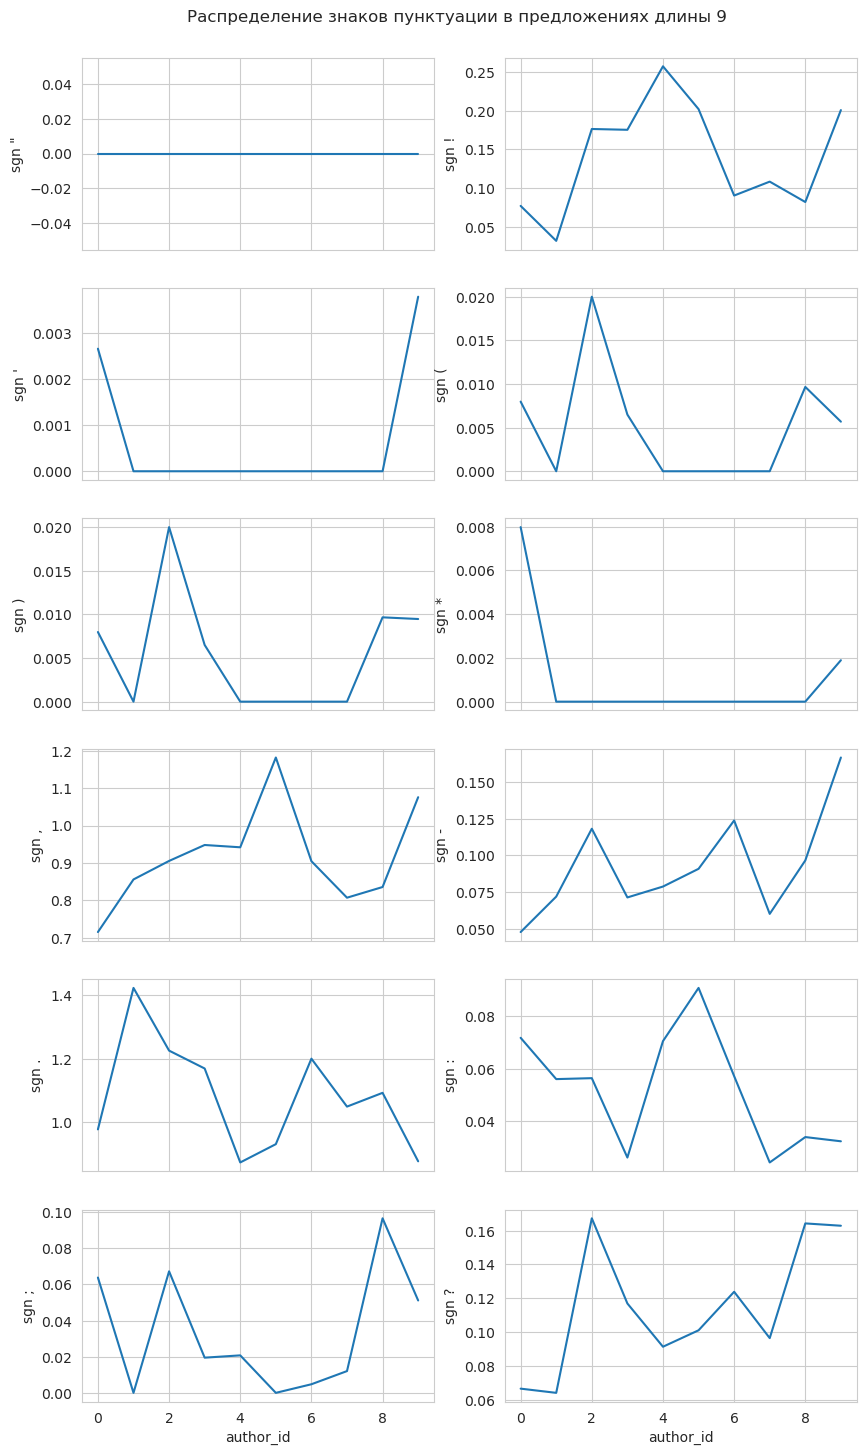

In [20]:
words = 9
pun = '"!\'()*,-.:;?'

fig, axes = plt.subplots(len(pun)//2, 2, figsize=(10, 16), sharex=True)
fig.suptitle(f"Распределение знаков пунктуации в предложениях длины {words}")
plt.subplots_adjust(top=.95)
                    
for i in range(len(pun)):
    sign = "sgn " + pun[i]
    sns.lineplot(df_aggr[df_aggr["sentence_length"] == words][['author_id', sign]], x='author_id', y=sign, 
                 ax=axes[i//2][i%2])



In [ ]:
plt.subplots?